### 廢案
做 HCN/CO 的 ratio map

原本是想這樣的：  
湯底是 wask_v2  
只是改變了統一解析度時的卷積的方法（從 astropy 改用 modular CASA） 

總之請見最後一個 cell

In [ ]:
# modular

import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u 
from astropy.convolution import convolve_fft
from reproject import reproject_interp
from radio_beam import Beam
from casatasks import importfits, imsmooth, exportfits

In [26]:
# hand made function

def Save_as_FITS(the_file_name, ima_data, ref_header, ref_beam, beam_a_Beam): # 存檔芝士
    the_file_name = the_file_name + '.fits'
    the_header = ref_header.copy() # new header 是複製一個已知 header 的大部分...
    if beam_a_Beam == True: # ref_beam 是實際意義上的 Beam 的話
        the_header['BMAJ'] = ref_beam.major.to(u.deg).value
        the_header['BMIN'] = ref_beam.minor.to(u.deg).value
        the_header['BPA'] = ref_beam.pa.to(u.deg).value
    else: # ref_beam 是一個 header 的話
        the_header['BMAJ'] = ref_beam['BMAJ']
        the_header['BMIN'] = ref_beam['BMIN']
        the_header['BPA'] = ref_beam['BPA']
    fits.writeto(the_file_name, ima_data, the_header, overwrite=True)
    print(f'Successfully saved a new FITS file as {the_file_name}')


# 新網格機！
'''
input a hdul&&像素步長 in arcsec
return new_shape, new_wcs, 和定義的 header 本人 
'''
def reGrid(reGrid_obj, pixelStep_target): 
    reGrid_obj_header = reGrid_obj[0].header
    ori_n1, ori_n2 = reGrid_obj[0].data.squeeze().shape # (y, x)
    new_n2 = int(ori_n2*abs(reGrid_obj_header['CDELT1']) / (pixelStep_target/3600)) # 要純量相除！
    new_n1 = int(ori_n1*abs(reGrid_obj_header['CDELT2']) / (pixelStep_target/3600))
    new_header = fits.Header()
    new_header['NAXIS'] = 2
    new_header['NAXIS1'] = new_n2
    new_header['NAXIS2'] = new_n1
    new_header['CRPIX1'] = new_n2 * 0.5 + 1
    new_header['CRPIX2'] = new_n1 * 0.5 + 1
    new_header['CRVAL1'] = 213.2915 # 暴力抓蟲
    new_header['CRVAL2'] = -65.339 # 暴力抓蟲
    new_header['CDELT1'] = pixelStep_target / -3600
    new_header['CDELT2'] = pixelStep_target / 3600
    new_header['CTYPE1'] = 'RA---SIN'
    new_header['CTYPE2'] = 'DEC--SIN'
    new_header['CUNIT1'] = 'deg'
    new_header['CUNIT2'] = 'deg'
    new_header['BMAJ'] = reGrid_obj_header['BMAJ']
    new_header['BMIN'] = reGrid_obj_header['BMIN']
    new_header['BPA'] = reGrid_obj_header['BPA']
    print('Giving reprojecting material...')
    return (new_n2, new_n1), WCS(new_header), new_header

In [ ]:
# import data

CO_Nsigma, HCN_Nsigma = (2.2, 2.2) # 這邊可以快速換換分別要幾個 sigma 的
CO_path = f"/Users/aqing/Documents/1004/Circinus_galaxy/Ratio-Map/mvpData/CO(1-0)_mom0_{CO_Nsigma}sigma.fits"
HCN_path = "/Users/aqing/Documents/1004/Circinus_galaxy/Ratio-Map/mvpData/HCN(1-0)_mom0_"+str(HCN_Nsigma)+"sigma.fits"
CO_hdul = fits.open(CO_path)
HCN_hdul = fits.open(HCN_path)

CO_header, HCN_header = CO_hdul[0].header, HCN_hdul[0].header 
CO_ima, HCN_ima = CO_hdul[0].data.squeeze(), HCN_hdul[0].data.squeeze()
CO_wcs, HCN_wcs = WCS(CO_header, naxis=2), WCS(HCN_header, naxis=2)

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [28]:
# regridding

pixelStep = 0.4 # arcsec
CO_new_shape, CO_new_wcs, CO_new_header = reGrid(CO_hdul, pixelStep)
CO_ima_reproj, _ = reproject_interp((CO_ima, CO_wcs), CO_new_wcs, shape_out=CO_new_shape)
HCN_ima_reproj, _ = reproject_interp((HCN_ima, HCN_wcs), CO_new_wcs, shape_out=CO_new_shape) # 寄生

HCN_new_header = CO_new_header.copy()
HCN_header['BMAJ'] = HCN_header['BMAJ']
HCN_header['BMIN'] = HCN_header['BMIN']
HCN_header['BPA'] = HCN_header['BPA']


Giving reprojecting material...


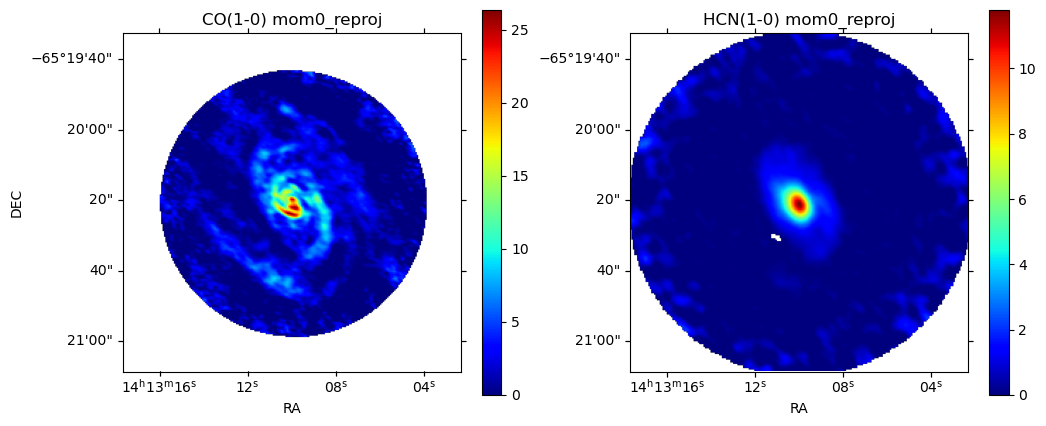

In [29]:
# show the regrid ima

fig_rg, ax = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={'projection': CO_new_wcs}) # 是這樣設座標的
im1 = ax[0].imshow(CO_ima_reproj, cmap='jet', vmin=0) # 要指定物件
fig_rg.colorbar(im1, ax=ax[0]) # call the obj
ax[0].set_title("CO(1-0) mom0_reproj")
ax[0].set_xlabel('RA')
ax[0].set_ylabel('DEC')
im2 = ax[1].imshow(HCN_ima_reproj, cmap='jet', vmin=0)
fig_rg.colorbar(im2, ax=ax[1]) 
ax[1].set_title("HCN(1-0) mom0_reproj")
ax[1].set_xlabel('RA')
ax[1].set_ylabel(' ')
#ax[1].set_ylabel('DEC')
plt.show()

In [ ]:
thePath = '/Users/aqing/Documents/1004/Circinus_galaxy/Ratio-Map/mvpData/HCN-CO/HCN-CO_wask_v2/' # 路徑
theFile = 'CO(1-0)_mom0_2.2sigma_regrid0.4.fits' # 檔名，不含後綴
fits_in = f'{thePath}{theFile}.fits'
smoothing_file = 'CO_casa.image' # 轉換進來的東西拿去 smooth
casa_out = f'{theFile}_sm.image'
#fits_out = f'{theFile}_smoothed111.fits' # 幹幹幹這個寫不進去


CO_beam, HCN_beam = Beam.from_fits_header(CO_header), Beam.from_fits_header(HCN_header) # 原始束寬應該和投影過後的束寬一樣
tarBeam = {'major': '3arcsec', 'minor': '3arcsec', 'pa': '0deg'}

'''
import 進來之後就叫 casa.image
反正是中間產物，就一直 overwrite 就好
'''
casa_in = 'casa.image'
casa_out = 'casa_smoothed.image'

importfits(fitsimage=CO_path, imagename=casa_in, overwrite=True, beam=CO_beam) 
imsmooth(imagename=casa_in, outfile=casa_out,
         kernel='gauss', beam=tarBeam, overwrite=True)
exportfits(imagename=casa_out, fitsimage='CO_imsmooth.fits', overwrite=True)
#
importfits(fitsimage=HCN_path, imagename='HCN_casa.image', overwrite=True, beam=HCN_beam)
imsmooth(imagename=casa_in, outfile=casa_out,
         kernel='gauss', beam=tarBeam, overwrite=True)
exportfits(imagename=casa_out, fitsimage='HCN_imsmooth.fits', overwrite=True)

### 雞掰這蟹想超麻煩的啊？
因為要一直在 casa 和小蛇之間轉換  
他存成 fits 檔我還要重讀一次，油餅  
這個就當廢案了